# Bitcoin: price predictions project

The goal for this project:

Apply RNN, deep learning algorithm, to predict Bitcoin(BTC) prices!

I am using RNN since it is often used for Time Series Forecasting. For this project, I chose to make this a Univariate Regression problem (It could be a multivariate problem), algorithm will be used on the dataset I've created from web scraping! Please check out 'BTC_Scraper' ipython notebook to see how I created this dataset using Selenium. 

## Dataset

In [511]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import and create an instance for the scaler, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler 

# This imports libraries needed to create our model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Import EarlyStopping to stop the fitting when the val_loss starts to increase instead of decreasing
from tensorflow.keras.callbacks import EarlyStopping

# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

btc = pd.read_csv('CMC_BTC_DS.csv')
btc.head()

,Date,Open,High,Low,Close,Volumn
0,"Aug 08, 2020","11,604.55","11,800.06","11,558.43","11,754.05","17,572,057,837"
1,"Aug 07, 2020","11,778.89","11,898.04","11,408.59","11,601.47","23,132,312,867"
2,"Aug 06, 2020","11,749.87","11,902.34","11,598.71","11,779.77","23,400,740,340"
3,"Aug 05, 2020","11,203.82","11,786.62","11,158.29","11,747.02","24,411,254,471"
4,"Aug 04, 2020","11,246.20","11,385.38","11,094.15","11,205.89","21,250,197,042"


I spelt 'Volume' wrong as 'Volumn'. Other than that, seems good.

In [512]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2660 non-null   object
 1   Open    2660 non-null   object
 2   High    2660 non-null   object
 3   Low     2660 non-null   object
 4   Close   2660 non-null   object
 5   Volumn  2660 non-null   object
dtypes: object(6)
memory usage: 124.8+ KB


There are no missing data and the column types are all objects while it should be numerical data. I'll be converting them into numerical type except for 'Date'. 'Date' will be converted to Datetime type.

In [513]:
# Converting 'Date' object to datetime type
btc['Date'] = pd.to_datetime(btc['Date'])

# Converts Open/High/Low/Close/Volume column to float data type respectively
btc.Open = btc.Open.astype(str)
btc.Open = btc.Open.str.replace(",","").astype(float)

btc.High = btc.High.astype(str)
btc.High = btc.High.str.replace(",","").astype(float)

btc.Low = btc.Low.astype(str)
btc.Low  = btc.Low.str.replace(",","").astype(float)

btc.Close = btc.Close.astype(str)
btc.Close = btc.Close.str.replace(",","").astype(float)

btc.Volumn = btc.Volumn.astype(str)
btc.Volumn = btc.Volumn.str.replace(",","").astype(float)

The order of the dataframe is in descending order, I want to make it ascending based on the date. I will also create a new column 'Weighted_price' using the average of 'High', 'Low', and 'Close' columns.

In [514]:
# Rename the 'Volumn' column
btc = btc.rename(columns={'Volumn':'Volume'})

# Added a new column for the Weighted price
btc['Weighted_price'] = ((btc['High'] + btc['Low'] + btc['Close'])/3)

# Sort 'Date' in ascending order
btc = btc.sort_values('Date')

## Splitting dataset

After making sure the data type is what I want, I am going to split the dataset into a train and test set

In [515]:
# The train set will not include the last 10 timestamp
train_set = btc.iloc[:-10]

# The test set will include the last 10 timestamp
test_set = btc.iloc[-10:]

**The test set will only be use for the final evaluation**

Looks like everything is good to go, time to move onto the EDA.

## EDA

Here are what each column means:
* Open: An open candle is when we jump onto another time stamp and starts a new candle at that exact price
* High: High is the max price reached at the specific time stamp candle 
* Low: Low is the min price reached at the specific time stamp candle
* Close: A close candle is whe price reach right before the start of a new candle in the next timestamp
* Volume: Self-explanatory, in USD


Text(0.5, 1.0, 'BTC')

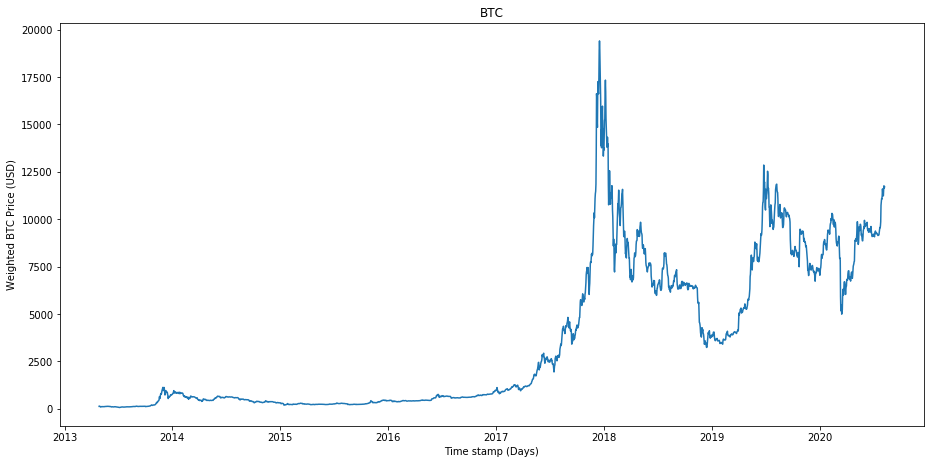

In [516]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=[15,7])

# Add set of axes to figure
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(btc.Date, btc.Weighted_price, '-')
axes.set_xlabel('Time stamp (Days)') # Notice the use of set_ to begin methods
axes.set_ylabel('Weighted BTC Price (USD)')
axes.set_title('BTC')

# RNN

A problem with using RNN as a learning algorithm is that it requires more of a clear pattern & seasonality and knowing bitcoin, there are usually no patterns since it's a highly manipulative asset. **I will be bulding models with and without Time Series Generator**. With time series generator, as the model tries to forecast further into the future, the errors that it may picked up while trying to forecasting will be magnified the further we try to forecast. I'll prove this by using the testset and comparing to the forecasted data. 

## Scaling

NN requires scaling so we need to scale our label especially since they're going to feed output back into themselves. I still plan on scaling to the training dataset only and not include the testset to prevent data leakage.


In [517]:
# Created new train dataframe with the Date and label only, which should be sorted by ascending date order already
train = pd.DataFrame(train_set[['Date','Weighted_price']])

# Create new test dataframe with the Date and label only, sorted by ascending date order already
test = pd.DataFrame(test_set[['Date','Weighted_price']])

In [518]:
# Set values between 0-1 to aboid domination of high values
scale = MinMaxScaler(feature_range=(0,1))

# Scaled from training set only to prevent data leakage and any form of cheating
scale.fit(np.array(train['Weighted_price']).reshape(-1,1))

# Transform on train and test sets
train_scaled = scale.transform(np.array(train['Weighted_price']).reshape(-1,1))
test_scaled = scale.transform(np.array(test['Weighted_price']).reshape(-1,1))

# Without Time series generator 

In [527]:
# Created X, y train and test sets
X_train = train.index
y_train = train_scaled
X_test = test.index
y_test = scale.inverse_transform(test_scaled)

# Converting to array 
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_train = np.array(y_train)

# Reshaping for NN
X_train = X_train.reshape(X_train.shape[0], 1, 1)
X_test = X_test.reshape(X_test.shape[0], 1, 1)

In [520]:
# Model building
nt_model = Sequential()

# Adding one layer with 100 LSTM specialized neurons with rectified linear unit as the activation function
nt_model.add(LSTM(100, activation='relu', input_shape=(None,1)))

# Final output layer with one neuron
nt_model.add(Dense(1))

# Compiling the model with adam as the variant descent gradient
nt_model.compile(optimizer='adam', loss='mse')

In [379]:
# Fitting model with generator
nt_model.fit(X_train, y_train, epochs=25, batch_size=1)

Epoch 1/25
2650/2650 [==============================] - 2s 881us/step - loss: 0.6149
Epoch 2/25
2650/2650 [==============================] - 2s 872us/step - loss: 0.3983
Epoch 3/25
2650/2650 [==============================] - 2s 868us/step - loss: 0.1912
Epoch 4/25
2650/2650 [==============================] - 2s 864us/step - loss: 0.4105
Epoch 5/25
2650/2650 [==============================] - 2s 904us/step - loss: 0.1278
Epoch 6/25
2650/2650 [==============================] - 2s 864us/step - loss: 0.1199
Epoch 7/25
2650/2650 [==============================] - 2s 867us/step - loss: 0.1225
Epoch 8/25
2650/2650 [==============================] - 2s 929us/step - loss: 0.1166
Epoch 9/25
2650/2650 [==============================] - 2s 904us/step - loss: 0.0988
Epoch 10/25
2650/2650 [==============================] - 2s 924us/step - loss: 0.0636
Epoch 11/25
2650/2650 [==============================] - 2s 908us/step - loss: 0.0378
Epoch 12/25
2650/2650 [==============================] - 2s 920

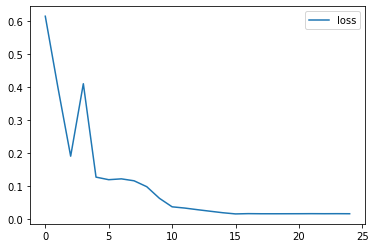

In [380]:
# Plot loss
lossess = pd.DataFrame(nt_model.history.history)
lossess.plot()

## Evaluate on test data w/o generator

In [411]:
# Predictions using X_test
nt_model_pred = nt_model.predict(X_test)

# Since the true predictions are scaled, we need to unscale it to compare with the test set that we separated earlier
true_predictionss = scale.inverse_transform(nt_model_pred)

# Reporting metrics
print('MAE:', mean_absolute_error(y_test, true_predictionss))
print('RMSE:', np.sqrt(mean_squared_error(y_test, true_predictionss)))

# Creates a new column 'Predictions' onto the test set
test['Predictions w/o generator'] = true_pred

MAE: 4391.883080729166
RMSE: 4843.591831369923


# With Time series generator

Time series generator is used to form batches to feed into the NN. Each batch will contain a desired amount of datapoints and each datapoint can be configured with any number of sequences. Time series generator is good when there are actual seasonality and trends in a period. I don't think there is seasonality in bitcoin but I will use time series generator anyways. I will be comparing the RNN model with the generator again the RNN model without the generator. By implementing time series generator, when we're trying to predict bitcoin prices, it will use a sequence of timestamps (100 in our case) to predict the price (1 in our case). 

In [521]:
# Im setting up the length of 100 which hopfully will capture potential entire period 
length = 100

# Creating a generator using train_scaled as a source of x, y, length of 100, and feeding in 1 batch (expect 1 output value) at a time.
generator = TimeseriesGenerator(train_scaled, train_scaled, length=100, batch_size=1)

In [522]:
# Using only one feature for the time series
n_features = 1

In [536]:
# Model creation
model = Sequential()

# Adding one layer with 100 LSTM specialized neurons with rectified linear unit as the activation function
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

# Final output layer with one neuron
model.add(Dense(1))

# Compiling the model with adam as the variant descent gradient
model.compile(optimizer='adam', loss='mse')

In [537]:
# Shows the final model summary
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [539]:
#Variable instance for the early stop function
early_stop = EarlyStopping(monitor= 'val_loss', verbose=1,patience=5)

# Since we used a generator, to forecast, for RNN to used the validation data, the validation data has to be a generator too.
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=9, batch_size=1)

# Fitting model with generator
model.fit(generator, epochs=25, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/25
2550/2550 [==============================] - 59s 23ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 2/25
2550/2550 [==============================] - 59s 23ms/step - loss: 5.8320e-04 - val_loss: 2.0888e-04
Epoch 3/25
2550/2550 [==============================] - 56s 22ms/step - loss: 4.1096e-04 - val_loss: 4.5163e-04
Epoch 4/25
2550/2550 [==============================] - 53s 21ms/step - loss: 2.9313e-04 - val_loss: 2.1352e-04
Epoch 5/25
2550/2550 [==============================] - 54s 21ms/step - loss: 2.6596e-04 - val_loss: 2.8092e-04
Epoch 6/25
2550/2550 [==============================] - 59s 23ms/step - loss: 2.3635e-04 - val_loss: 3.1338e-10
Epoch 7/25
2550/2550 [==============================] - 58s 23ms/step - loss: 2.1848e-04 - val_loss: 1.9296e-04
Epoch 8/25
2550/2550 [==============================] - 61s 24ms/step - loss: 1.9180e-04 - val_loss: 1.0980e-04
Epoch 9/25
2550/2550 [==============================] - 54s 21ms/step - loss: 1.9126e-04 - val_loss: 3.4015e-05


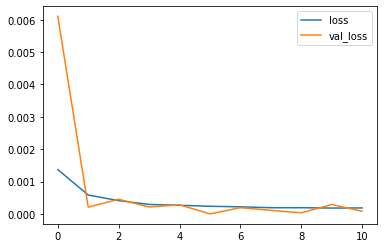

In [540]:
# Plot loss & val_loss
losses = pd.DataFrame(model.history.history)
losses.plot()

The loss and val_loss has leveled out which is what I need. There isn't any overfitting that had occurred.

## Evaluate on test data w/ generator

In [541]:
test_predictions = []

# I'm creating a batch using the last 100 elements of the train_saled to the begining of the testset so when I compare the forecast and testset, it'll have matching timestamps
first_eval_batch = train_scaled[-100:]

# Reshaping the batch since it needs to have the same shape since rNN expects it. Predicts one timestamp ahead
current_batch = first_eval_batch.reshape((1, 100, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [542]:
# Since the true predictions are scaled, we need to unscale it to compare with the test set that we separated earlier
true_predictions = scale.inverse_transform(test_predictions)

# Reporting metrics
print('MAE:', mean_absolute_error(y_test, true_predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, true_predictions)))

MAE: 603.497780936719
RMSE: 694.6163794687727


In [421]:
# Creates a new column 'Predictions' onto the test set
test['Predictions w/ generator'] = true_predictions

In [423]:
# Setting test dataframe index with 'Date'
test.set_index('Date',inplace=True)

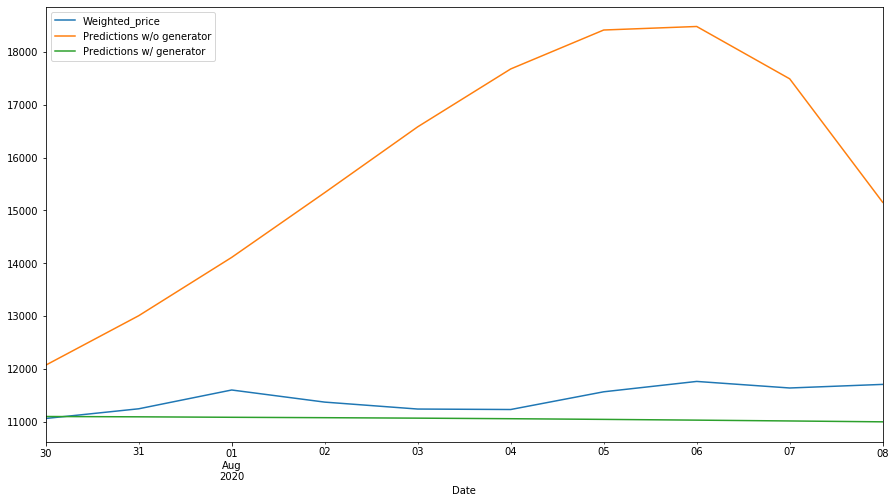

In [424]:
# Plot predictions from different models against actual test label
test.plot(figsize=(15,8))

# Forcasting into the unknown

The RNN model with the time series generator performed better than the RNN model without time series generator. I will build an RNN model with the time series generator using the entire dataset to predict into the unknown.

In [543]:
full_set = btc[['Date', 'Weighted_price']]

In [544]:
# Set values between 0-1 to aboid domination of high values
full_scale = MinMaxScaler(feature_range=(0,1))

# Scaled from training set only to prevent data leakage and any form of cheating
full_scale.fit(np.array(full_set['Weighted_price']).reshape(-1,1))

# Transform on train and test sets
full_scaled = full_scale.transform(np.array(full_set['Weighted_price']).reshape(-1,1))

In [545]:
# Created generator for the model
generator = TimeseriesGenerator(full_scaled, full_scaled, length=100, batch_size=1)

# Model creation
f_model = Sequential()

# Adding one layer with 100 LSTM specialized neurons with rectified linear unit as the activation function
f_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

# Final output layer with one neuron
f_model.add(Dense(1))

# Compiling the model with adam as the variant descent gradient
f_model.compile(optimizer='adam', loss='mse')

In [546]:
f_model.fit(generator, epochs=11)

Epoch 1/11
2560/2560 [==============================] - 59s 23ms/step - loss: 0.0010
Epoch 2/11
2560/2560 [==============================] - 57s 22ms/step - loss: 4.9163e-04
Epoch 3/11
2560/2560 [==============================] - 54s 21ms/step - loss: 3.4850e-04
Epoch 4/11
2560/2560 [==============================] - 54s 21ms/step - loss: 2.7172e-04
Epoch 5/11
2560/2560 [==============================] - 55s 22ms/step - loss: 2.4092e-04
Epoch 6/11
2560/2560 [==============================] - 57s 22ms/step - loss: 2.1626e-04
Epoch 7/11
2560/2560 [==============================] - 61s 24ms/step - loss: 1.8097e-04
Epoch 8/11
2560/2560 [==============================] - 54s 21ms/step - loss: 1.9665e-04
Epoch 9/11
2560/2560 [==============================] - 54s 21ms/step - loss: 1.8648e-04
Epoch 10/11
2560/2560 [==============================] - 59s 23ms/step - loss: 1.7375e-04
Epoch 11/11
2560/2560 [==============================] - 60s 23ms/step - loss: 1.7569e-04


In [551]:
forecast = []

# I'm creating a batch till the begining of the testset so when I compare the forecast and testset, it'll have matching timestamps
first_eval_batch = full_scaled[-100:]

# Reshaping the batch since it needs to have the same shape since rNN expects it. Predicts one timestamp ahead
current_batch = first_eval_batch.reshape((1, 100, n_features))

# 20 is how many timestamps I want to forecast
for i in range(20):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [552]:
# Since the forecast is scaled, we need to inverse transform it
forecast = full_scale.inverse_transform(forecast)

In [554]:
# Created a function that will return a list that had 20 elements of dates
def date_time(): 
    date = []
    for i in range(20):
        date.append('Aug ' + str(9+i) + ', 2020')
    return date

In [555]:
# Created a dataframe for the forecast
forecasted = pd.DataFrame(data=forecast, columns=['Weighted_price'])

# Added 'Date' column and filled the values using the date_time function I created
forecasted['Date'] = date_time()

# Converting 'Date' object to datetime type
forecasted['Date'] = pd.to_datetime(forecasted['Date'])

In [556]:
# Concat the original full set with the new forecast dataset I created
con = pd.concat([full_set, forecasted], axis=0)

# Setting the index with the 'Date' column
con.set_index('Date',inplace=True)

con

,Weighted_price
Date,
2013-04-28,134.096667
2013-04-29,142.010000
2013-04-30,139.993333
2013-05-01,121.533333
2013-05-02,107.696667
...,...
2020-08-24,10884.665530
2020-08-25,10836.127072
2020-08-26,10788.202734


Text(0.5, 1.0, 'BTC')

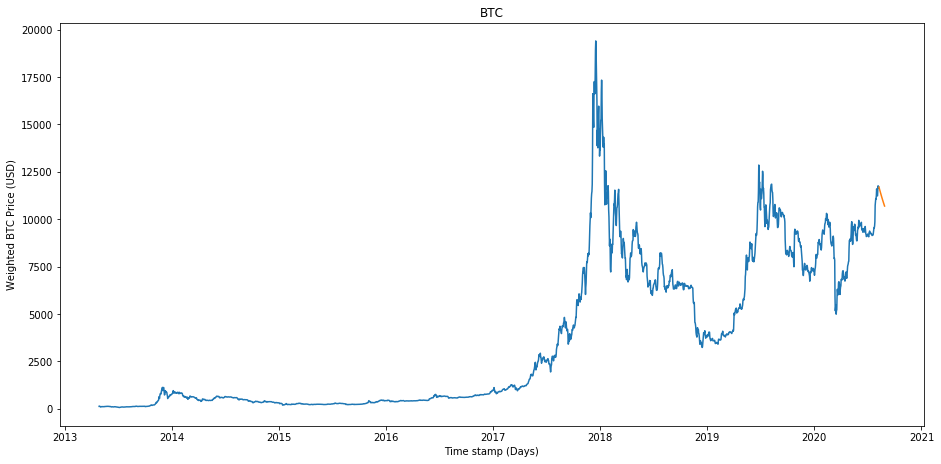

In [558]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=[15,7])

# Add set of axes to figure
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(full_set.Date, full_set.Weighted_price, '-')
axes.plot(forecasted.Date, forecasted.Weighted_price, '-')
axes.set_xlabel('Time stamp (Days)') # Notice the use of set_ to begin methods
axes.set_ylabel('Weighted BTC Price (USD)')
axes.set_title('BTC')

## RNN conclusion

In this project, I've built two different RNN model; 
* RNN **without** Time Series Generator
    * MAE: 4391.883080729166
    * RMSE: 4843.591831369923
* RNN **with** Time Series Generator
    * MAE: 603.497780936719
    * RMSE: 694.6163794687727

The RNN model with the time series generator had better performance than the RNN model without time series generator. By using RNN model with time series generator, as the model tries to forecast further into the future, the errors that it may picked up while trying to forecast will be magnified the further we try to forecast because the model will be forecasting the forecasted. Fortunately the testset had only 10 timestamp but, if we do decide to forcast even furthur, we will notice the performance drop the further we forcast.